# Car sales analysis and modeling

Rusty Bargain used car sales service wants to develop an app to attract new customers. In the app, an important feature includes quickly finding out the market value of a customer's car. The goal was to use used car historical data to build a model  to determine the value of a used car, so the customer is informed how much they might make on the market. Three models were originally created to test the quality of the price predictions, but also the time it takes the model to gather the predictions. A evaluation comparison was done on the three models, and the best performing model was used for the final evaluation.

## Data preparation

### Importing libraries

In [1]:
# Load libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from collections import defaultdict
from functools import partial
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import time

### Data preprocessing

1. <b>Convert data types:</b>

    - There are three date fields in the dataset: <b><mark>DateCrawled</mark></b>, <b><mark>DateCreated</mark></b>, and <b><mark>LastSeen</mark></b>.  Since the three fields are more than likely not features, it might not be required to convert the date fields to a *dateime* data type, but just a precaution the date fields were converted.<br><br>

2. <b>Missing values:</b>

    - There are five fields that contained missing values: <b><mark>VehicleType</mark></b>, <b><mark>Gearbox</mark></b>, <b><mark>Model</mark></b>, <b><mark>FuelType</mark></b>, and <b><mark>NotRepaired</mark></b>. Given the amount of missing values - roughly ~180k (not including potential overlap) - it was decided to replace the missing values with the string value <b>Unknown</b> so that the records could be preserved for model training.<br><br>
 
3. <b>Duplicate values:</b>

    - There are 262 duplicate rows in the dataset. These records have been removed. Also, there was no need to identify duplicate values of a particular field because all such instances would be considered valid duplicates. For example, it is possible to have two used cars with the brand Audi, same fuel type, price, etc.<br><br>

4. <b>Remove outliers / bad data:</b>

    - The <b><mark>RegistrationYear</mark></b> field had many years that did not make logical sense and weren't even valid years. It was decided that valid years had to be in the range of 1800 to 2019. There were 171 records that fell beyond this range. These records were removed from the dataset.

#### Data overview

In [2]:
# Load data into a pandas DataFrame
url = 'https://raw.githubusercontent.com/rmodesitt/data-projects-TripleTen/refs/heads/main/car-sales-analysis/car_data.csv'
car_df = pd.read_csv(url)

In [3]:
# Display DataFrame basic info
display(car_df.info())
display(car_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


#### Convert data types

In [4]:
# Convert date fields to datetime data type
car_df['DateCrawled'] = pd.to_datetime(car_df['DateCrawled'], format='%d/%m/%Y %H:%M')
car_df['DateCreated'] = pd.to_datetime(car_df['DateCreated'], format='%d/%m/%Y %H:%M')
car_df['LastSeen'] = pd.to_datetime(car_df['LastSeen'], format='%d/%m/%Y %H:%M')
display(car_df.info())
display(car_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Mileage            354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:00,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:00
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:00
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:00
3,2016-03-17 16:54:00,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:00
4,2016-03-31 17:25:00,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:00


#### Replace missing values

In [5]:
# Identify missing values
display(car_df.isna().sum())

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [6]:
# Replace missing values in DataFrame
car_df.fillna('unknown', inplace=True)
display(car_df.isna().sum())
print()
display(car_df['VehicleType'].value_counts())

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

sedan          91457
small          79831
wagon          65166
unknown        37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

#### Remove duplicates

In [7]:
# Identify duplicate rows
print()
print('# of duplicates:', car_df.duplicated().sum())
display(car_df[car_df.duplicated(keep=False)].sort_values('DateCrawled'))


# of duplicates: 262


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
136532,2016-03-05 14:11:00,3700,coupe,2006,manual,101,astra,150000,7,gasoline,opel,no,2016-03-03,0,55218,2016-03-06 03:44:00
238082,2016-03-05 14:11:00,3700,coupe,2006,manual,101,astra,150000,7,gasoline,opel,no,2016-03-03,0,55218,2016-03-06 03:44:00
51617,2016-03-05 14:12:00,2689,small,2005,auto,61,fortwo,90000,7,petrol,smart,no,2016-03-03,0,56412,2016-04-05 04:49:00
53329,2016-03-05 14:12:00,2689,small,2005,auto,61,fortwo,90000,7,petrol,smart,no,2016-03-03,0,56412,2016-04-05 04:49:00
234836,2016-03-05 14:13:00,17000,wagon,2009,manual,170,a4,150000,9,gasoline,audi,no,2016-03-03,0,35792,2016-04-07 03:45:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309829,2016-04-06 20:06:00,9890,wagon,2007,auto,136,c_klasse,150000,12,gasoline,mercedes_benz,no,2016-04-06,0,65760,2016-04-06 20:06:00
53426,2016-04-06 21:25:00,3900,sedan,1999,manual,116,beetle,150000,6,petrol,volkswagen,no,2016-04-06,0,55469,2016-04-06 21:25:00
1771,2016-04-06 21:25:00,3900,sedan,1999,manual,116,beetle,150000,6,petrol,volkswagen,no,2016-04-06,0,55469,2016-04-06 21:25:00
50917,2016-04-06 23:25:00,2990,small,2002,manual,60,lupo,80000,8,petrol,volkswagen,no,2016-04-06,0,61250,2016-04-06 23:25:00


In [8]:
# Remove duplicate values in DataFrame
print('Length of car_df with duplicates:', len(car_df))
car_df = car_df.drop_duplicates().reset_index(drop=True)
print('Length of car_df with removed duplicates:', len(car_df))

Length of car_df with duplicates: 354369
Length of car_df with removed duplicates: 354107


#### Remove outliers

In [9]:
# Identify all RegistrationYear values
unique_year = car_df['RegistrationYear'].unique()
display(np.sort(unique_year))

# Remove rows with years below 1800 and above 2019
print('Current length of car_df:', len(car_df))
car_df_bad_year = car_df[(car_df['RegistrationYear'].between(1000, 1800)) | (car_df['RegistrationYear'].between(2066, 9999))]
print('Number of years outside of accepted range:', len(car_df_bad_year))

car_df = car_df.drop(car_df_bad_year.index, axis=0)
car_df = car_df.reset_index(drop=True)
print('New length of car_df after removal of year outliers:', len(car_df))

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Current length of car_df: 354107
Number of years outside of accepted range: 171
New length of car_df after removal of year outliers: 353936


### Data overview / Exploratory data analysis 

To get a better idea of how certain fields might be affecting price and to what extent, basic exploratory analysis was performed illustrating potential correlations that could be seen in future modeling.

1. <b>Value counts</b>

    - Value counts of the <b><mark>VehicleType</mark></b>, <b><mark>Gearbox</mark></b>, and <b><mark>FuelType</mark></b> fields were gathered and plotted. These charts are merely informational and do not answer any questions about relationships and correlation. It provides a more detailed visual outlook on the what data consists of.<br><br>

2. <b>Price analysis</b>

    - How is car price affected by the year of the car? Mileage? Brand? Are there any direct correlations?
    
        - <b><mark>RegistrationYear</mark></b>: Interestingly the year of the car in relation to price forms a parabola. Earlier cars made in the 1970s have pretty high prices. As the years get newer, the car prices decrease with the 1990s representing the cheapest cars. The newest cars, the 2000s, are the most expensive. The resulting pattern represents a convex U-shaped parabola.
        
        - <b><mark>Mileage</mark></b>: The relationship between car price and mileage was expected. The higher the mileage of the car, the lower the average price. There was one expection with the mileage bin / box plot of 0-5000 representing the cheapest cars, and with lots of outliers. New cars or cars that have not been used at all should represent the highest prices. After looking into the data, there are lots of smaller novelty cars, like golf carts, etc., that have not been used much that account for a lot of the lower prices that you see in this range. This is where <b><mark>Model</mark></b> would come into play in a machine learning model.
        
        - <b><mark>Brand</mark></b>: Is the price of a car affected by mileage differently if the car is a top car brand? Does mileage matter if the brand is a "top-notch" brand? The answer is not really. Even with high mileages, expensive cars are still going to be expensive given the brand of the car. For lower priced cars, in terms of brand, car mileage has more of an affect on the price.

#### Value count comparison

VehicleType


sedan          91399
small          79753
wagon          65115
unknown        37313
bus            28752
convertible    20180
coupe          16147
suv            11991
other           3286
Name: VehicleType, dtype: int64

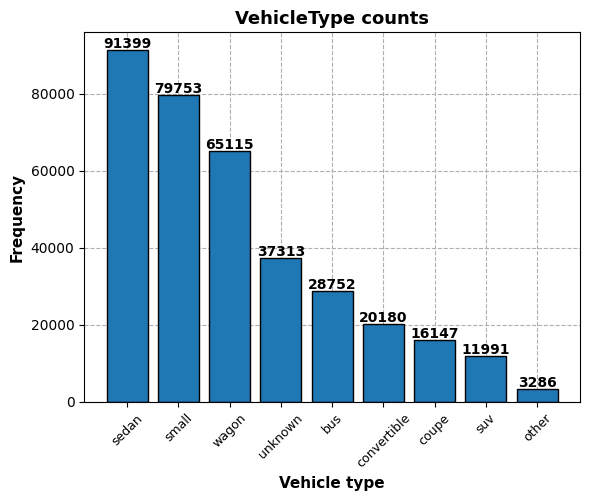

In [10]:
# Find unique values and counts of VehicleType field
print('VehicleType')
counts_VehicleType = car_df['VehicleType'].value_counts()
display(counts_VehicleType)

# Bar chart of total counts
# Build bar chart
fig, ax = plt.subplots()
barchart = ax.bar(counts_VehicleType.index, counts_VehicleType.values, zorder=2, edgecolor='black')
plt.xlabel('Vehicle type', fontweight='bold', fontsize=11)
plt.xticks(rotation=45, fontsize=9)
plt.ylabel('Frequency', fontweight='bold', fontsize=11)
plt.title('VehicleType counts', fontweight='bold', fontsize=13)
for bar in barchart:
    height = bar.get_height()
    ax.text(x=bar.get_x() + bar.get_width() / 2, y=height + 500, s=height, ha='center', fontweight='bold')
    
# Add gridlines
ax.set_axisbelow(True)
ax.grid(linestyle='--')

# Display chart
plt.show()

Gearbox


manual     268008
auto        66236
unknown     19692
Name: Gearbox, dtype: int64

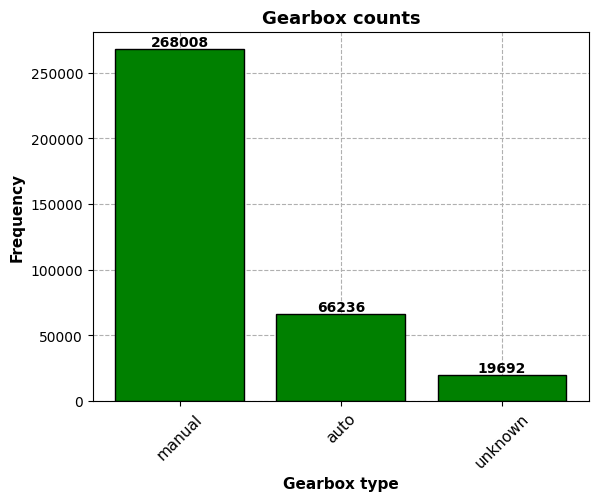

In [11]:
# Find unique values and counts of Gearbox field
# Gearbox
print('Gearbox')
counts_Gearbox = car_df['Gearbox'].value_counts()
display(counts_Gearbox)

# Build bar chart
fig, ax = plt.subplots()
barchart = ax.bar(counts_Gearbox.index, counts_Gearbox.values, color='green', zorder=2, edgecolor='black')
plt.xlabel('Gearbox type', fontweight='bold', fontsize=11)
plt.xticks(rotation=45, fontsize=11)
plt.ylabel('Frequency', fontweight='bold', fontsize=11)
plt.title('Gearbox counts', fontweight='bold', fontsize=13)
for bar in barchart:
    height = bar.get_height()
    ax.text(x=bar.get_x() + bar.get_width() / 2, y=height + 2000, s=height, ha='center', fontweight='bold')

# Add gridlines
ax.set_axisbelow(True)
ax.grid(linestyle='--')

# Display chart
plt.show()

FuelType


petrol      216127
gasoline     98651
unknown      32761
lpg           5307
cng            564
hybrid         233
other          203
electric        90
Name: FuelType, dtype: int64

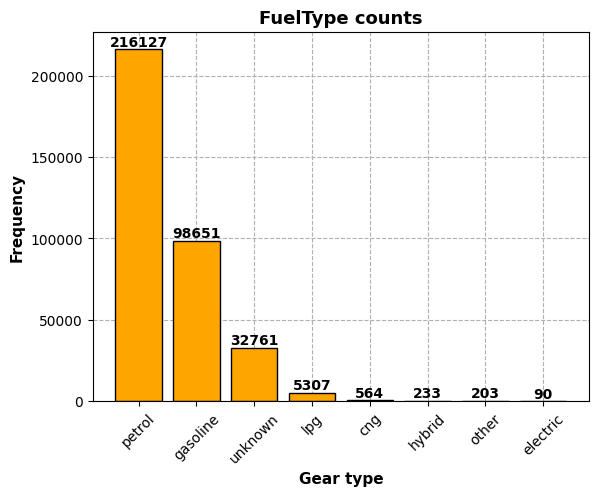

In [12]:
# Find unique values and counts of FuelType field
print('FuelType')
counts_FuelType = car_df['FuelType'].value_counts()
display(counts_FuelType)

# Build bar chart
fig, ax = plt.subplots()
barchart = ax.bar(counts_FuelType.index, counts_FuelType.values, color='orange', zorder=2, edgecolor='black')
plt.xlabel('Gear type', fontweight='bold', fontsize=11)
plt.xticks(rotation=45, fontsize=10)
plt.ylabel('Frequency', fontweight='bold', fontsize=11)
plt.title('FuelType counts', fontweight='bold', fontsize=13)
for bar in barchart:
    height = bar.get_height()
    ax.text(x=bar.get_x() + bar.get_width() / 2, y=height + 2000, s=height, ha='center', fontweight='bold')

# Add gridlines
ax.set_axisbelow(True)
ax.grid(linestyle='--')

# Display chart
plt.show()

#### Price analysis

<b>Is there a correlation between car price and year?</b>

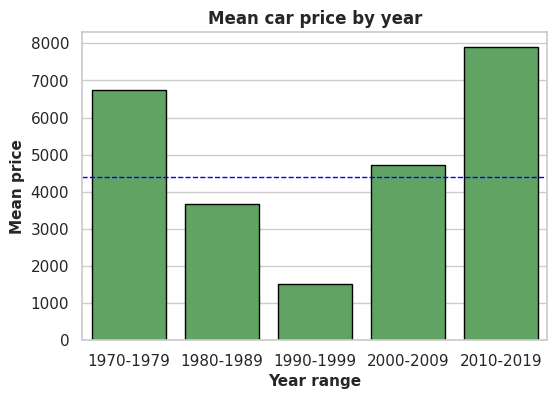

In [13]:
# Data preparation for bar chart
bins = [1970, 1980, 1990, 2000, 2010, 2020]
labels = ['1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2019']
car_df_adjusted = car_df.copy()
car_df_adjusted = car_df_adjusted[car_df_adjusted['RegistrationYear'] > 1969]
car_df_adjusted['YearRange'] = pd.cut(car_df_adjusted['RegistrationYear'], bins=bins, labels=labels, right=False)
year_grouped = car_df_adjusted.groupby('YearRange')['Price'].mean().round(2).reset_index()
mean_price = car_df_adjusted['Price'].mean().round(2)

# Plot bar chart
sns.set(style='whitegrid')
sns.set_theme(style='whitegrid')
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=year_grouped, x='YearRange', y='Price', palette=['#56ae57'], edgecolor='black')
ax.axhline(mean_price, color='blue', linestyle='--', linewidth=1)
plt.title('Mean car price by year', fontsize=12, fontweight='bold')
plt.xlabel('Year range', fontsize=11, fontweight='bold')
plt.ylabel('Mean price', fontsize=11, fontweight='bold')
plt.show()

<b>What is the distribution between car mileage relative to price? Does car brand affect the mileage relative to price?</b>

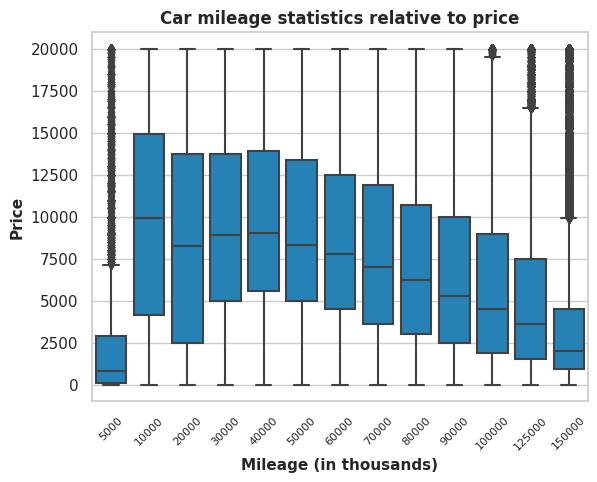

In [14]:
# Plot box plot
sns.set(style="whitegrid")
sns.set_theme(style='whitegrid')
ax = sns.boxplot(data=car_df_adjusted, x='Mileage', y='Price', showfliers=True, palette=['#0e87cc'])
plt.title('Car mileage statistics relative to price', fontsize=12, fontweight='bold')
plt.xlabel('Mileage (in thousands)', fontsize=11, fontweight='bold')
plt.xticks(rotation=45, fontsize=8)
plt.ylabel('Price', fontsize=11, fontweight='bold')
plt.show()

In [15]:
# Determine highest and lowest priced car brands (by mean)
price_group = car_df_adjusted.groupby('Brand')['Price'].mean().round(2).sort_values().reset_index()
mileage_group = car_df_adjusted.groupby('Brand')['Mileage'].mean().round(2).sort_values().reset_index()
price_mileage = pd.merge(price_group, mileage_group, how='inner', on='Brand').sort_values('Price')
top_10_brands = price_mileage.tail(20)
bottom_10_brands = price_mileage.head(20)
display(top_10_brands)
display(bottom_10_brands)

,Brand,Price,Mileage
20,suzuki,3878.72,107163.79
21,seat,3999.03,122914.19
22,nissan,4085.19,121220.62
23,volvo,4232.78,141005.37
24,volkswagen,4378.99,131101.86
25,toyota,4774.59,118480.43
26,sonstige_autos,4815.56,94062.08
27,kia,4986.24,112101.95
28,hyundai,5112.11,105879.89
29,chevrolet,5480.52,102173.40


,Brand,Price,Mileage
0,daewoo,1017.81,123376.38
1,rover,1313.29,135423.55
2,trabant,1632.10,55463.32
3,daihatsu,1693.66,119044.67
4,renault,2265.96,128315.07
5,lancia,2324.65,126303.42
6,fiat,2662.65,117555.43
7,opel,2723.71,129540.44
8,mitsubishi,2935.75,127842.94
9,lada,3037.44,75266.67


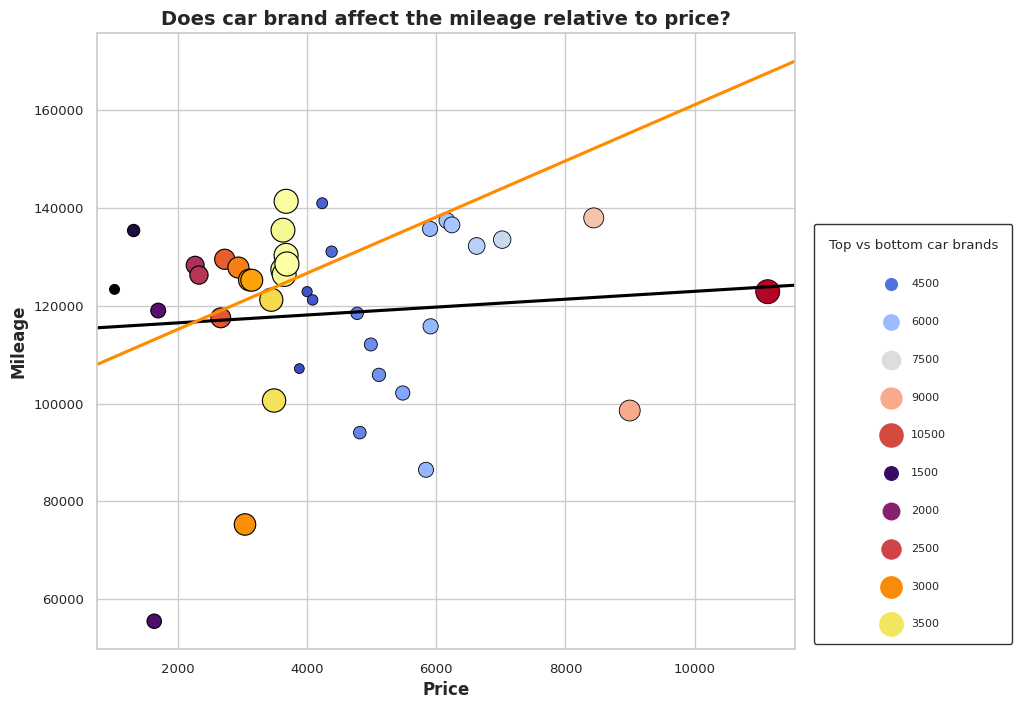

In [16]:
# Create plot figure
plt.figure(figsize=(9, 8))
plt.xlim(750, 11550)

# Plot scatter plots and regression lines
sns.scatterplot(data=top_10_brands, x='Price', y='Mileage', hue='Price',
                size='Price', palette='coolwarm', edgecolor='black', sizes=(50, 300))
sns.regplot(x=top_10_brands['Price'],
            y=top_10_brands['Mileage'], scatter=False, color='black', ci=None, truncate=False)
sns.scatterplot(data=bottom_10_brands, x='Price', y='Mileage', hue='Price',
                size='Price', palette='inferno', edgecolor='black', sizes=(50, 300))
sns.regplot(x=bottom_10_brands['Price'],
            y=bottom_10_brands['Mileage'], scatter=False, color='darkorange', ci=None, truncate=False)

# Add title, axis labels, and legend
plt.xlabel('Price', fontweight='bold')
plt.xticks(fontsize=9.5)
plt.ylabel('Mileage', fontweight='bold')
plt.yticks(fontsize=9.5)
plt.title(label='Does car brand affect the mileage relative to price?', fontweight='bold', fontsize=14)
legend = plt.legend(title='Top vs bottom car brands', title_fontsize=9.5, bbox_to_anchor=(1.32, 0), loc='lower right', 
                    labelspacing=2.5, fontsize=8, facecolor='white', frameon=True, edgecolor='black', borderpad=1.3)

# Display plot
plt.grid(True)
plt.show()

## Model training

### Model preparation

1. <b>Features and target</b>:

    - The following fields were not included as features because they do not provide relevant information for predicting the price of a used car. The target, <b><mark>Price</mark></b>, was also removed.

        - <b><mark>DateCrawled</mark></b>
        - <b><mark>DateCreated</mark></b>
        - <b><mark>PostalCode</mark></b>
        - <b><mark>LastSeen</mark></b>
        - <b><mark>NumberOfPictures</mark></b><br><br>

2. <b>One-hot encoding</b>:

    - One-hot encoding was performed to transform categorical features to numerical. This created a total of 312 columns.<br><br>

3. <b>Training, validation, and test datasets</b>:

    - The data was split into training, validation, and test datasets with a 60 / 20 / 20 split. This ensures that there is ample data to accurately train the model, but still have sets to validate and test the evaluation of the model.<br><br>

4. <b>Feature scaling</b>:

    - There was great range and variety in the values of numerical features, so feature scaling was performed to scale and standardize the data so certain features weren't unfairly weighted. The scaled features included:
        
        - <b><mark>RegistrationYear</mark></b>
        - <b><mark>Power</mark></b>
        - <b><mark>Mileage</mark></b>
        - <b><mark>RegistrationMonth</mark></b>

<b>Features and target</b>

In [63]:
# Define features and target variables
features = car_df.drop(['DateCrawled', 'Price', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures'], axis=1)
target = car_df['Price']

<b>One-hot encoding</b>

In [64]:
# Transform categorical features to numerical features
features = pd.get_dummies(features, drop_first=True)
display(features)

,RegistrationYear,Power,Mileage,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,1993,0,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,2011,190,125000,5,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2004,163,125000,8,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,2001,75,150000,6,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,2008,69,90000,7,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353931,2005,0,150000,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
353932,2005,0,20000,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
353933,2000,101,125000,3,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
353934,1996,102,150000,3,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


<b>Training, validation, and test datasets</b>

In [65]:
# Split data into training, validation, and test datasets
car_df_train_features, car_df_test_features, car_df_train_target, car_df_test_target = train_test_split(features, target, 
                                                                                            test_size=0.2, random_state=100)
car_df_train_features, car_df_val_features, car_df_train_target, car_df_val_target = train_test_split(car_df_train_features, 
                                                                                                      car_df_train_target, test_size=0.25, 
                                                                                                      random_state=100)

<b>Feature scaling</b>

In [66]:
# Define list of variables to be standardized and scaled
standardize_list = ['RegistrationYear', 'Power', 'Mileage', 'RegistrationMonth']

# Create scaler instance and standardize features for all datasets
scaler = StandardScaler()
scaler.fit(car_df_train_features[standardize_list])
scaler.fit(car_df_test_features[standardize_list])
scaler.fit(car_df_val_features[standardize_list])

car_df_train_features[standardize_list] = scaler.transform(car_df_train_features[standardize_list])
car_df_test_features[standardize_list] = scaler.transform(car_df_test_features[standardize_list])
car_df_val_features[standardize_list] = scaler.transform(car_df_val_features[standardize_list])

display(car_df_train_features.head())

/tmp/ipykernel_136/3432020867.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df_test_features[standardize_list] = scaler.transform(car_df_test_features[standardize_list])
/opt/conda/envs/python3/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,RegistrationYear,Power,Mileage,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
317007,-1.067757,-0.611469,0.57346,-1.534443,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
236965,-0.539586,0.755569,0.57346,1.686654,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
126974,1.044929,0.169695,0.57346,-0.460744,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
286616,-0.671629,-0.042335,0.57346,-0.729169,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
195792,-0.803671,-0.611469,0.57346,0.612955,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Model building

#### Decision Tree Regression

The first model is a Decision Tree Regression model. A base model with no modifications or tuning was first built and trained to establish a baseline. Then, tuning of certain hyperparameters was performed to optimize the model's performance and to improve the model. Both models were evaluated by the *root mean squared error (RMSE)* metric. Finally, a sanity check was performed against a Linear Regression model to validate the model is useful and the right improvements were made.

Hyperparameter values tested:

- <b>max_depth</b>: 1, 20, 40, 60, 80, 100
- <b>min_samples_leaf</b>: 1, 20, 40, 60, 80, 100
- <b>min_samples_split</b>: 2, 20, 40, 60, 80, 100

<b>Base model</b>

In [23]:
# Create and train model
model_dt = DecisionTreeRegressor(random_state=50)

start = time.time()
model_dt.fit(car_df_train_features, car_df_train_target)
end = time.time()
time_train_base = round(end - start, 2)

# Gather predictions
start = time.time()
predictions = model_dt.predict(car_df_val_features)
end = time.time()
time_predict_base = round(end - start, 2)

# Evaluate model witn RMSE and times to run
MSE_base = mean_squared_error(car_df_val_target, predictions)
RMSE_base = MSE_base**0.5
print('RMSE:', RMSE_base.round(2))
print('Training time:', time_train_base)
print('Prediction time:', time_predict_base)
print()

# Get depth, lowest # of samples, highest # of samples, and median # of samples
print('Maximum depth of tree: ', model_dt.get_depth())
print('# of nodes: ', len(model_dt.tree_.value))
print('# of leaves:', model_dt.tree_.n_leaves)
print('Minimum # of samples on a node: ', np.min(model_dt.tree_.n_node_samples))
print('Maximum # of samples on a node: ', np.max(model_dt.tree_.n_node_samples))
print('Median samples per node: ', np.median(model_dt.tree_.n_node_samples))

# Display a subset of targets vs predictions
predictions2 = pd.Series(predictions, name='preds').reset_index(drop=True)
car_df_val_target2 = car_df_val_target.reset_index(drop=True).rename('targets')
combine = pd.concat([car_df_val_target2, predictions2], axis=1)
display(combine.head(15))

RMSE: 2234.68
Training time: 5.18
Prediction time: 0.09

Maximum depth of tree:  84
# of nodes:  326815
# of leaves: 163408
Minimum # of samples on a node:  1
Maximum # of samples on a node:  212361
Median samples per node:  2.0


,targets,preds
0,3100,2200.0
1,6690,6945.0
2,4650,4650.0
3,600,300.0
4,0,15500.0
5,4100,4199.0
6,7450,7800.0
7,700,900.0
8,1250,1480.0
9,1800,2000.0


<b>Hyperparameter tuning</b>

In [24]:
# Compare max_depth values
for depth in [1] + list(range(20, 101, 20)):
    model_dt = DecisionTreeRegressor(max_depth=depth, random_state=50)
    model_dt.fit(car_df_train_features, car_df_train_target)
    predictions = model_dt.predict(car_df_val_features)
    print('max_depth =', depth, '|| ', end='')
    MSE = mean_squared_error(car_df_val_target, predictions)
    RMSE = MSE**0.5
    print('RMSE:', RMSE)

max_depth = 1 || RMSE: 3786.072625843077
max_depth = 20 || RMSE: 2108.4080519566614
max_depth = 40 || RMSE: 2221.009254426507
max_depth = 60 || RMSE: 2230.6874076286954
max_depth = 80 || RMSE: 2233.7773683925425
max_depth = 100 || RMSE: 2234.681649701128


In [25]:
# Compare min_samples_leaf values
for leaf in [1] + list(range(20, 101, 20)):
    model_dt = DecisionTreeRegressor(min_samples_leaf=leaf, random_state=50)
    model_dt.fit(car_df_train_features, car_df_train_target)
    predictions = model_dt.predict(car_df_val_features)
    print('min_samples_leaf: =', leaf, '|| ', end='')
    MSE = mean_squared_error(car_df_val_target, predictions)
    RMSE = MSE**0.5
    print('RMSE:', RMSE)

min_samples_leaf: = 1 || RMSE: 2234.681649701128
min_samples_leaf: = 20 || RMSE: 1948.3707282173643
min_samples_leaf: = 40 || RMSE: 1984.966775675518
min_samples_leaf: = 60 || RMSE: 2029.061257041194
min_samples_leaf: = 80 || RMSE: 2053.1375732372103
min_samples_leaf: = 100 || RMSE: 2082.805075887625


In [26]:
# Compare min_samples_split values
for split in [2] + list(range(20, 101, 20)):
    model_dt = DecisionTreeRegressor(min_samples_split=split, random_state=50)
    model_dt.fit(car_df_train_features, car_df_train_target)
    predictions = model_dt.predict(car_df_val_features)
    print('min_samples_split: =', split, '|| ', end='')
    MSE = mean_squared_error(car_df_val_target, predictions)
    RMSE = MSE**0.5
    print('RMSE:', RMSE)

min_samples_split: = 2 || RMSE: 2234.681649701128
min_samples_split: = 20 || RMSE: 2001.581715589662
min_samples_split: = 40 || RMSE: 1964.4456618553945
min_samples_split: = 60 || RMSE: 1944.6814280201265
min_samples_split: = 80 || RMSE: 1941.3348936821722
min_samples_split: = 100 || RMSE: 1944.0464194819265


In [27]:
# Create parameter grid
param_grid_dt = {'max_depth': [20, 40, 60],
                'min_samples_leaf': [20, 40, 60],
                 'min_samples_split': [60, 80, 100]}

# Create gridsearch object
model_dt_grid = DecisionTreeRegressor(random_state=50)
grid_search_dt = GridSearchCV(estimator=model_dt_grid, param_grid=param_grid_dt, cv=5, scoring='neg_root_mean_squared_error')

# Fit model and identify best hyperparameter combinations
grid_search_dt.fit(car_df_train_features, car_df_train_target)
grid_search_dt.cv_results_
dict_dt = defaultdict(partial(np.ndarray, 0))
dict_dt['params'] = grid_search_dt.cv_results_['params']
dict_dt['split0_test_score'] = grid_search_dt.cv_results_['split0_test_score']
dict_dt['split1_test_score'] = grid_search_dt.cv_results_['split1_test_score']
dict_dt['split2_test_score'] = grid_search_dt.cv_results_['split2_test_score']
dict_dt['mean_test_score'] = grid_search_dt.cv_results_['mean_test_score']
print('Best hyperparameters:', grid_search_dt.best_params_)
print('Best RMSE:', abs(grid_search_dt.best_score_))
print()
print()
display(dict_dt)

Best hyperparameters: {'max_depth': 40, 'min_samples_leaf': 20, 'min_samples_split': 60}
Best RMSE: 1996.1579727665642




defaultdict(functools.partial(<class 'numpy.ndarray'>, 0),
            {'params': [{'max_depth': 20,
               'min_samples_leaf': 20,
               'min_samples_split': 60},
              {'max_depth': 20,
               'min_samples_leaf': 20,
               'min_samples_split': 80},
              {'max_depth': 20,
               'min_samples_leaf': 20,
               'min_samples_split': 100},
              {'max_depth': 20,
               'min_samples_leaf': 40,
               'min_samples_split': 60},
              {'max_depth': 20,
               'min_samples_leaf': 40,
               'min_samples_split': 80},
              {'max_depth': 20,
               'min_samples_leaf': 40,
               'min_samples_split': 100},
              {'max_depth': 20,
               'min_samples_leaf': 60,
               'min_samples_split': 60},
              {'max_depth': 20,
               'min_samples_leaf': 60,
               'min_samples_split': 80},
              {'max_depth': 20,
 

<b>Sanity check</b>

In [28]:
# Create and train optimized Decision Tree model
model_dt = grid_search_dt.best_estimator_

start = time.time()
model_dt.fit(car_df_train_features, car_df_train_target)
end = time.time()
time_train_opt = round(end - start, 2)

# Gather predictions
start = time.time()
predictions = model_dt.predict(car_df_val_features)
end = time.time()
time_predict_opt = round(end - start, 2)

# Evaluate model witn RMSE
MSE_opt = mean_squared_error(car_df_val_target, predictions)
RMSE_opt = MSE_opt**0.5

# Display a subset of targets vs predictions
predictions2 = pd.Series(predictions, name='preds').reset_index(drop=True)
combine = pd.concat([car_df_val_target2, predictions2], axis=1)
display(combine.head(15))

,targets,preds
0,3100,2292.390244
1,6690,6451.960000
2,4650,3698.627451
3,600,1709.413043
4,0,11637.392857
5,4100,5091.250000
6,7450,8409.833333
7,700,554.270270
8,1250,1055.431818
9,1800,2928.800000


In [29]:
# Create and train Linear Regression model
lr_model = LinearRegression()

start = time.time()
lr_model.fit(car_df_train_features, car_df_train_target)
end = time.time()
time_train_lr = round(end - start, 2)

# Gather predictions
start = time.time()
predictions = lr_model.predict(car_df_val_features)
end = time.time()
time_predict_lr = round(end - start, 2)

In [30]:
# Compare RMSEs and times to run
MSE_lr = mean_squared_error(car_df_val_target, predictions)
RMSE_lr = MSE_lr**0.5
print('RMSE of optimzed Decision Tree model:', abs(RMSE_opt.round(2)))
print('Training time:', time_train_opt)
print('Prediction time:', time_predict_opt)
print()
print('RMSE of Linear Regression model:', RMSE_lr.round(2))
print('Training time:', time_train_lr)
print('Prediction time:', time_predict_lr)

RMSE of optimzed Decision Tree model: 1949.32
Training time: 4.7
Prediction time: 0.07

RMSE of Linear Regression model: 2902.39
Training time: 11.78
Prediction time: 0.11


<b>Conclusion</b>

The final Decision Tree model yielded a RMSE of <font color='red'><b>1949.32</b></font> with a training run time of <font color='red'><b>5.41</b></font> seconds and a prediction run time of <font color='red'><b>0.07</b></font> seconds. The fine-tuning did result in good improvement and it is performing much better than the Linear Regression model, so it also passes the sanity check. However, the gridsearch object did take over 6 minutes to complete. A different strategy will need to be taken for other models because there will be many more estimators resulting in very high run times.

<b>NOTE:</b> The time to run values in the below table may vary slightly compared to the times in the code cells since the time to run is variable from run to run.

In [31]:
# Compare all models
RMSE_table = [RMSE_base, RMSE_opt, RMSE_lr]
time_train_table = [time_train_base, time_train_opt, time_train_lr]
time_predict_table = [time_predict_base, time_predict_opt, time_predict_lr]
dt_table_dict = {
    'RMSE': RMSE_table,
    'Time to train (sec)': time_train_table,
    'Time to predict (sec)': time_predict_table
}
dt_table = pd.DataFrame(dt_table_dict, index=['Base model', 'Optimized model', 'Linear regression'])
display(dt_table)

,RMSE,Time to train (sec),Time to predict (sec)
Base model,2234.681650,5.18,0.09
Optimized model,1949.318661,4.70,0.07
Linear regression,2902.386914,11.78,0.11


#### Random Forest Regression

The second model is a Random Forest Regression. The same procedure was followed here for training and predicting - run a base model, perform hyperparameter tuning, and do a sanity check. However, given the increased number of estimators / trees in a Random Forest, there were time issues when running the model and the gridsearch. So, after running the base model, which has default of 100 estimators, the ideal number of estimators was first identified to limit the amount of time model training and tuning took, but without sacrifing accuracy / RMSE. The estimator value was then used as a fixed parameter for further fine-tuning and for the gridsearch object.

Hyperparameter values tested:

- <b>n_estimators</b>: 5, 10, 15, 25, 50, 100, 200
- <b>max_depth</b>: 1, 20, 40, 60
- <b>min_samples_leaf</b>: 1, 20, 40, 60
- <b>min_samples_split</b>: 2, 20, 40, 60

<b>Base model</b>

In [32]:
# Create and train model
model_rf = RandomForestRegressor(random_state=50)

start = time.time()
model_rf.fit(car_df_train_features, car_df_train_target)
end = time.time()
time_train_base = round(end - start, 2)

# Gather predictions
start = time.time()
predictions = model_rf.predict(car_df_val_features)
end = time.time()
time_predict_base = round(end - start, 2)

# Evaluate model witn RMSE
MSE_base = mean_squared_error(car_df_val_target, predictions)
RMSE_base = MSE_base**0.5
print('RMSE:', RMSE_base.round(2))
print('Training time:', time_train_base)
print('Prediction time:', time_predict_base)
print()

# Get max depth of forest
print('Maximum depth of forest: ', max(tree.get_depth() for tree in model_rf.estimators_))

# Display a subset of targets vs predictions
predictions2 = pd.Series(predictions, name='preds').reset_index(drop=True)
combine = pd.concat([car_df_val_target2, predictions2], axis=1)
display(combine.head(15))

RMSE: 1751.8
Training time: 324.78
Prediction time: 3.29

Maximum depth of forest:  94


,targets,preds
0,3100,2338.280000
1,6690,6762.574762
2,4650,4371.227500
3,600,663.920000
4,0,12833.998333
5,4100,3627.853333
6,7450,8041.967048
7,700,866.063333
8,1250,687.700000
9,1800,2428.890000


<b>Hyperparameter tuning</b>

The base model which included 100 estimators / trees took <b><font color='red'>4min 36s</font></b> to run. This is much to long of a run, so the code cell below was first used to determine an <mark>n_estimator</mark> value that would not take too long to run, but still resulted in an acceptable RMSE. The code cell below only shows the results with 5 estimators, but the value was updated several times to get the resulting RMSEs and times to run.

After testing many estimator values, it was concluded that <b><font color='red'>15</font></b> estimators would be used for further hyperparameter tuning and gridsearch object. The below table shows the detailed results.

In [33]:
# Update estimator value
estimator = 5

# Create and train model
model_rf = RandomForestRegressor(n_estimators=estimator, random_state=50)
model_rf.fit(car_df_train_features, car_df_train_target)

# Gather predictions
predictions = model_rf.predict(car_df_val_features)

# Evaluate model witn RMSE
MSE = mean_squared_error(car_df_val_target, predictions)
RMSE = MSE**0.5
print('RMSE:', RMSE.round(2))
print()

RMSE: 1872.37



In [34]:
# Display table of n_estimator results
RMSE_table = [1872, 1809, 1790, 1773, 1759, 1751, 1748]
time_to_run_table = [14, 27, 42, 67, 141, 271, 840]
rf_table_dict = {
    'RMSE': RMSE_table,
    'Time to run (sec)': time_to_run_table
}
rf_table = pd.DataFrame(rf_table_dict, index=[5, 10, 15, 25, 50, 100, 200])
display(rf_table)

,RMSE,Time to run (sec)
5,1872,14
10,1809,27
15,1790,42
25,1773,67
50,1759,141
100,1751,271
200,1748,840


In [35]:
# Compare max_depth values
for depth in [1] + list(range(20, 61, 20)):
    model_rf = RandomForestRegressor(max_depth=depth, n_estimators=15, random_state=50)
    model_rf.fit(car_df_train_features, car_df_train_target)
    predictions = model_rf.predict(car_df_val_features)
    print('max_depth =', depth, '|| ', end='')
    MSE = mean_squared_error(car_df_val_target, predictions)
    RMSE = MSE**0.5
    print('RMSE:', RMSE)

max_depth = 1 || RMSE: 3786.0728322512973
max_depth = 20 || RMSE: 1788.7622260594883
max_depth = 40 || RMSE: 1788.2009587063335
max_depth = 60 || RMSE: 1790.4675085688561


In [36]:
# Compare min_samples_leaf values
for leaf in [1] + list(range(20, 61, 20)):
    model_rf = RandomForestRegressor(min_samples_leaf=leaf, n_estimators=15, random_state=50)
    model_rf.fit(car_df_train_features, car_df_train_target)
    predictions = model_rf.predict(car_df_val_features)
    print('min_samples_leaf: =', leaf, '|| ', end='')
    MSE = mean_squared_error(car_df_val_target, predictions)
    RMSE = MSE**0.5
    print('RMSE:', RMSE)

min_samples_leaf: = 1 || RMSE: 1790.5670022411011
min_samples_leaf: = 20 || RMSE: 1874.318768589825
min_samples_leaf: = 40 || RMSE: 1950.333121934539
min_samples_leaf: = 60 || RMSE: 1997.5761662743928


In [37]:
# Compare min_samples_split values
for split in [2] + list(range(20, 61, 20)):
    model_rf = RandomForestRegressor(min_samples_split=split, n_estimators=15, random_state=50)
    model_rf.fit(car_df_train_features, car_df_train_target)
    predictions = model_rf.predict(car_df_val_features)
    print('min_samples_split: =', split, '|| ', end='')
    MSE = mean_squared_error(car_df_val_target, predictions)
    RMSE = MSE**0.5
    print('RMSE:', RMSE)

min_samples_split: = 2 || RMSE: 1790.5670022411011
min_samples_split: = 20 || RMSE: 1760.175060837297
min_samples_split: = 40 || RMSE: 1777.533279425672
min_samples_split: = 60 || RMSE: 1797.497137835817


In [38]:
# Create parameter grid
param_grid_rf = {'max_depth': [40, 60],
                 'min_samples_leaf': [1, 20],
                 'min_samples_split': [20]
                }

# Create gridsearch object
model_rf_grid = RandomForestRegressor(n_estimators=15, random_state=50)
grid_search_rf = GridSearchCV(estimator=model_rf_grid, param_grid=param_grid_rf, cv=5, scoring='neg_root_mean_squared_error')

# Fit model and identify best hyperparameter combinations
grid_search_rf.fit(car_df_train_features, car_df_train_target)
grid_search_rf.cv_results_
dict_rf = defaultdict(partial(np.ndarray, 0))
dict_rf['params'] = grid_search_rf.cv_results_['params']
dict_rf['split0_test_score'] = grid_search_rf.cv_results_['split0_test_score']
dict_rf['split1_test_score'] = grid_search_rf.cv_results_['split1_test_score']
dict_rf['split2_test_score'] = grid_search_rf.cv_results_['split2_test_score']
dict_rf['mean_test_score'] = grid_search_rf.cv_results_['mean_test_score']
print('Best hyperparameters:', grid_search_rf.best_params_)
print('Best RMSE score:', abs(grid_search_rf.best_score_))
print()
print()
display(dict_rf)

Best hyperparameters: {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 20}
Best RMSE score: 1787.2464131315974




defaultdict(functools.partial(<class 'numpy.ndarray'>, 0),
            {'params': [{'max_depth': 40,
               'min_samples_leaf': 1,
               'min_samples_split': 20},
              {'max_depth': 40,
               'min_samples_leaf': 20,
               'min_samples_split': 20},
              {'max_depth': 60,
               'min_samples_leaf': 1,
               'min_samples_split': 20},
              {'max_depth': 60,
               'min_samples_leaf': 20,
               'min_samples_split': 20}],
             'split0_test_score': array([-1779.6236768 , -1922.31042005, -1778.68074487, -1922.30997078]),
             'split1_test_score': array([-1811.03739543, -1950.32103651, -1811.79240796, -1950.31937439]),
             'split2_test_score': array([-1794.0018639 , -1913.29808598, -1795.11695083, -1913.2934062 ]),
             'mean_test_score': array([-1787.24641313, -1913.7000012 , -1787.37705105, -1913.69958754])})

<b>Sanity check</b>

In [40]:
# Create and train optimized Random Forest model
model_rf = grid_search_rf.best_estimator_

start = time.time()
model_rf.fit(car_df_train_features, car_df_train_target)
end = time.time()
time_train_opt = round(end - start, 2)

# Gather predictions
start = time.time()
predictions = model_rf.predict(car_df_val_features)
end = time.time()
time_predict_opt = round(end - start, 2)

# Evaluate model witn RMSE
MSE_opt = mean_squared_error(car_df_val_target, predictions)
RMSE_opt = MSE**0.5

# Display a subset of targets vs predictions
predictions2 = pd.Series(predictions, name='preds').reset_index(drop=True)
combine = pd.concat([car_df_val_target2, predictions2], axis=1)
display(combine.head(15))

,targets,preds
0,3100,2522.826315
1,6690,6154.926704
2,4650,4406.900808
3,600,1006.272462
4,0,10589.562830
5,4100,3906.367698
6,7450,8117.379142
7,700,643.500494
8,1250,805.701809
9,1800,2242.795089


In [41]:
# Compare RMSEs and times to run
print('RMSE of optimzed Random Forest model:', abs(RMSE_opt.round(2)))
print('Training time:', time_train_opt)
print('Prediction time:', time_predict_opt)
print()
print('RMSE of Linear Regression model:', RMSE_lr.round(2))
print('Training time:', time_train_lr)
print('Prediction time:', time_predict_lr)

RMSE of optimzed Random Forest model: 1797.5
Training time: 46.69
Prediction time: 0.33

RMSE of Linear Regression model: 2902.39
Training time: 11.78
Prediction time: 0.11


<b>Conclusion</b>

The final Random Forest model yielded a RMSE of <font color='red'><b>1797.50</b></font> with a training run time of <font color='red'><b>46.69</b></font> seconds and a prediction run time of <font color='red'><b>0.33</b></font>. The fine-tuned model yielded a very similar RMSE to the base model, but it takes <font color='red'><b>4 minutes less</b></font> to run. Also, the model performs much better than the Linear Regression model, so it passes the sanity check. Without updating the <mark>n_estimator</mark> parameter to a lower value, the fine-tuning process would have taken multiple hours. Moreover, lowering the <mark>n_estimator</mark> parameter from <b>100</b> to <b>15</b> saved a lot of time, only increased the RMSE slightly, and the model still is effective and efficient.

<b>NOTE:</b> The time to run values in the below table may vary slightly compared to the times in the code cells since the time to run is variable from run to run.

In [43]:
# Compare Random Forest and Linear Regression models
RMSE_table = [RMSE_base, RMSE_opt, RMSE_lr]
time_train_table = [time_train_base, time_train_opt, time_train_lr]
time_predict_table = [time_predict_base, time_predict_opt, time_predict_lr]
rf_table_dict = {
    'RMSE': RMSE_table,
    'Time to train (sec)': time_train_table,
    'Time to predict (sec)': time_predict_table
    
}
rf_table = pd.DataFrame(rf_table_dict, index=['Base model', 'Optimized model', 'Linear regression'])
display(rf_table)

,RMSE,Time to train (sec),Time to predict (sec)
Base model,1751.800830,324.78,3.29
Optimized model,1797.497138,46.69,0.33
Linear regression,2902.386914,11.78,0.11


#### LightGBM (Gradient boosting)

The third model is a LightGBM gradient boosting model, with the idea that each subsequent model takes into account the errors of the previous. The same procedure was followed here for training and predicting - run a base model, perform hyperparameter tuning, and do a sanity check. Similar to the Random Forest Regression, only a few parameters were tested and fine-tuned within the gridsearch object to limit long time run issues.

Hyperparametervalues tested:

- <b>num_leaves</b>: 31, 63
- <b>max_depth</b>: -1, 3
- <b>learning_rate</b>: 0.01, 0.1

<b>Base model</b>

In [44]:
# Create parameter grid
fixed_params = {
    'boosting': 'gbdt',
    'objective': 'regression', 
    'metric': 'rmse',
    'verbose': -1,
    'n_estimators': 1000
}

# Create and train model
model_lgm = lgb.LGBMRegressor(**fixed_params, random_state=50)

start = time.time()
model_lgm.fit(car_df_train_features, car_df_train_target, eval_set=(car_df_val_features, car_df_val_target))
end = time.time()
time_train_base = round(end - start, 2)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[1]	valid_0's rmse: 4196.74
[2]	valid_0's rmse: 3926.43
[3]	valid_0's rmse: 3691.15
[4]	valid_0's rmse: 3485.5
[5]	valid_0's rmse: 3304.93
[6]	valid_0's rmse: 3149.29
[7]	valid_0's rmse: 3012.93
[8]	valid_0's rmse: 2895.01
[9]	valid_0's rmse: 2792.05
[10]	valid_0's rmse: 2700.79
[11]	valid_0's rmse: 2617.04
[12]	valid_0's rmse: 2550.33
[13]	valid_0's rmse: 2489.75
[14]	valid_0's rmse: 2435.3
[15]	valid_0's rmse: 2384.68
[16]	valid_0's rmse: 2342.68
[17]	valid_0's rmse: 2305
[18]	valid_0's rmse: 2269.93
[19]	valid_0's rmse: 2241.21
[20]	valid_0's rmse: 2213.31
[21]	valid_0's rmse: 2187.04
[22]	valid_0's rmse: 2163.3
[23]	valid_0's rmse: 2141.35
[24]	valid_0's rmse: 2119.27
[25]	valid_0's rmse: 2102.27
[26]	valid_0's rmse: 2086.88
[27]	valid_0's rmse: 2067.65
[28]	valid_0's rmse: 2053.81
[29]	valid_0's rmse: 2040.62
[30]	valid_0's rmse: 2028.54
[31]	valid_0's rmse: 2016.67
[32]	val

[275]	valid_0's rmse: 1761.49
[276]	valid_0's rmse: 1761.28
[277]	valid_0's rmse: 1761.22
[278]	valid_0's rmse: 1760.77
[279]	valid_0's rmse: 1760.38
[280]	valid_0's rmse: 1760.2
[281]	valid_0's rmse: 1760.12
[282]	valid_0's rmse: 1759.72
[283]	valid_0's rmse: 1759.6
[284]	valid_0's rmse: 1759.44
[285]	valid_0's rmse: 1759.34
[286]	valid_0's rmse: 1759.22
[287]	valid_0's rmse: 1758.98
[288]	valid_0's rmse: 1758.93
[289]	valid_0's rmse: 1758.79
[290]	valid_0's rmse: 1758.6
[291]	valid_0's rmse: 1758.22
[292]	valid_0's rmse: 1758.13
[293]	valid_0's rmse: 1757.97
[294]	valid_0's rmse: 1757.63
[295]	valid_0's rmse: 1757.53
[296]	valid_0's rmse: 1757.42
[297]	valid_0's rmse: 1757.34
[298]	valid_0's rmse: 1757.35
[299]	valid_0's rmse: 1757.14
[300]	valid_0's rmse: 1756.99
[301]	valid_0's rmse: 1756.98
[302]	valid_0's rmse: 1756.86
[303]	valid_0's rmse: 1756.79
[304]	valid_0's rmse: 1756.65
[305]	valid_0's rmse: 1756.3
[306]	valid_0's rmse: 1756.15
[307]	valid_0's rmse: 1756.04
[308]	valid_0'

[556]	valid_0's rmse: 1730.03
[557]	valid_0's rmse: 1729.93
[558]	valid_0's rmse: 1729.95
[559]	valid_0's rmse: 1729.9
[560]	valid_0's rmse: 1729.84
[561]	valid_0's rmse: 1729.8
[562]	valid_0's rmse: 1729.73
[563]	valid_0's rmse: 1729.7
[564]	valid_0's rmse: 1729.59
[565]	valid_0's rmse: 1729.56
[566]	valid_0's rmse: 1729.47
[567]	valid_0's rmse: 1729.32
[568]	valid_0's rmse: 1729.31
[569]	valid_0's rmse: 1729.25
[570]	valid_0's rmse: 1729.07
[571]	valid_0's rmse: 1729.08
[572]	valid_0's rmse: 1728.99
[573]	valid_0's rmse: 1728.96
[574]	valid_0's rmse: 1728.97
[575]	valid_0's rmse: 1728.93
[576]	valid_0's rmse: 1728.85
[577]	valid_0's rmse: 1728.81
[578]	valid_0's rmse: 1728.91
[579]	valid_0's rmse: 1728.81
[580]	valid_0's rmse: 1728.72
[581]	valid_0's rmse: 1728.56
[582]	valid_0's rmse: 1728.54
[583]	valid_0's rmse: 1728.5
[584]	valid_0's rmse: 1728.48
[585]	valid_0's rmse: 1728.31
[586]	valid_0's rmse: 1728.13
[587]	valid_0's rmse: 1728.07
[588]	valid_0's rmse: 1728.13
[589]	valid_0'

[834]	valid_0's rmse: 1715.8
[835]	valid_0's rmse: 1715.83
[836]	valid_0's rmse: 1715.77
[837]	valid_0's rmse: 1715.76
[838]	valid_0's rmse: 1715.8
[839]	valid_0's rmse: 1715.78
[840]	valid_0's rmse: 1715.67
[841]	valid_0's rmse: 1715.64
[842]	valid_0's rmse: 1715.59
[843]	valid_0's rmse: 1715.55
[844]	valid_0's rmse: 1715.51
[845]	valid_0's rmse: 1715.44
[846]	valid_0's rmse: 1715.38
[847]	valid_0's rmse: 1715.43
[848]	valid_0's rmse: 1715.29
[849]	valid_0's rmse: 1715.28
[850]	valid_0's rmse: 1715.24
[851]	valid_0's rmse: 1715.23
[852]	valid_0's rmse: 1715.26
[853]	valid_0's rmse: 1715.19
[854]	valid_0's rmse: 1715.21
[855]	valid_0's rmse: 1715.16
[856]	valid_0's rmse: 1715.03
[857]	valid_0's rmse: 1715.02
[858]	valid_0's rmse: 1715.01
[859]	valid_0's rmse: 1715.02
[860]	valid_0's rmse: 1714.99
[861]	valid_0's rmse: 1714.96
[862]	valid_0's rmse: 1714.9
[863]	valid_0's rmse: 1714.9
[864]	valid_0's rmse: 1714.79
[865]	valid_0's rmse: 1714.8
[866]	valid_0's rmse: 1714.82
[867]	valid_0's

In [45]:
# Gather predictions
start = time.time()
predictions = model_lgm.predict(car_df_val_features)
end = time.time()
time_predict_base = round(end - start, 2)

# Evaluate model witn RMSE
MSE_base = mean_squared_error(car_df_val_target, predictions)
RMSE_base = MSE_base**0.5
print('RMSE:', RMSE_base.round(2))
print('Training time:', time_train_base)
print('Prediction time:', time_predict_base)
print()

# Display a subset of targets vs predictions
predictions2 = pd.Series(predictions, name='preds').reset_index(drop=True)
combine = pd.concat([car_df_val_target2, predictions2], axis=1)
display(combine.head(15))

RMSE: 1710.31
Training time: 134.19
Prediction time: 3.99



,targets,preds
0,3100,2877.263479
1,6690,6602.446402
2,4650,4493.400268
3,600,955.890455
4,0,10339.136293
5,4100,4112.826249
6,7450,7627.728011
7,700,825.774850
8,1250,962.413124
9,1800,1832.488723


<b>Hyperparameter tuning</b>

In [46]:
# Create parameter grid
param_grid = {
    'num_leaves': [31, 63],
    'max_depth': [-1, 3],
    'learning_rate': [0.01, 0.1]
}

# Create gridsearch object
model_lgm_grid = lgb.LGBMRegressor(**fixed_params, random_state=50)
grid_searchlgm = GridSearchCV(estimator=model_lgm_grid, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fit model and identify best hyperparameter combinations
grid_searchlgm.fit(car_df_train_features, car_df_train_target)
grid_searchlgm.cv_results_
dict_lgm = defaultdict(partial(np.ndarray, 0))
dict_lgm['params'] = grid_searchlgm.cv_results_['params']
dict_lgm['split0_test_score'] = grid_searchlgm.cv_results_['split0_test_score']
dict_lgm['split1_test_score'] = grid_searchlgm.cv_results_['split1_test_score']
dict_lgm['split2_test_score'] = grid_searchlgm.cv_results_['split2_test_score']
dict_lgm['mean_test_score'] = grid_searchlgm.cv_results_['mean_test_score']
print('Best hyperparameters:', grid_searchlgm.best_params_)
print('Best RMSE score:', abs(grid_searchlgm.best_score_))
print()
print()
display(dict_lgm)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boostin

defaultdict(functools.partial(<class 'numpy.ndarray'>, 0),
            {'params': [{'learning_rate': 0.01,
               'max_depth': -1,
               'num_leaves': 31},
              {'learning_rate': 0.01, 'max_depth': -1, 'num_leaves': 63},
              {'learning_rate': 0.01, 'max_depth': 3, 'num_leaves': 31},
              {'learning_rate': 0.01, 'max_depth': 3, 'num_leaves': 63},
              {'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 31},
              {'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 63},
              {'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 31},
              {'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 63}],
             'split0_test_score': array([-1836.39044074, -1782.62849156, -2066.39362729, -2066.39362729,
                    -1713.26809409, -1700.30917786, -1842.20534871, -1842.20534871]),
             'split1_test_score': array([-1877.93363494, -1821.46473698, -2106.30009366, -2106.30009366,
                    

<b>Sanity check</b>

In [47]:
# Create and train optimized optimized LightGBM model
model_lgm = grid_searchlgm.best_estimator_

start = time.time()
model_lgm.fit(car_df_train_features, car_df_train_target)
end = time.time()
time_train_opt = round(end - start, 2)

# Gather predictions
start = time.time()
predictions = model_lgm.predict(car_df_val_features)
end = time.time()
time_predict_opt = round(end - start, 2)

# Evaluate model witn RMSE
MSE_opt = mean_squared_error(car_df_val_target, predictions)
RMSE_opt = MSE_opt**0.5

# Display a subset of targets vs predictions
predictions2 = pd.Series(predictions, name='preds').reset_index(drop=True)
combine = pd.concat([car_df_val_target2, predictions2], axis=1)
display(combine.head(15))

RMSE: 1797.5


,targets,preds
0,3100,2820.455424
1,6690,6063.409761
2,4650,3859.998827
3,600,485.369631
4,0,11121.285527
5,4100,3801.243680
6,7450,7406.667050
7,700,737.367504
8,1250,950.015456
9,1800,1854.364977


In [48]:
# Compare RMSEs and times to run
print('RMSE of LightGBM model:', abs(RMSE_opt.round(2)))
print('Training time:', time_train_opt)
print('Prediction time:', time_predict_opt)
print()
print('RMSE of Linear Regression model:', RMSE_lr.round(2))
print('Training time:', time_train_lr)
print('Prediction time:', time_predict_lr)

RMSE of LightGBM model: 1683.65
Training time: 23.3
Prediction time: 5.51

RMSE of Linear Regression model: 2902.39
Training time: 11.78
Prediction time: 0.11


<b>Conclusion</b>

The final LightGBM boosting model yielded a RMSE of <font color='red'><b>1683.65</b></font> with a training run time of <font color='red'><b>23.3</b></font> seconds and a prediction run time of <font color='red'><b>5.51</b></font>. The fine-tuning did result in decent improvement and it is performing much better than the Linear Regression model, so it also passes the sanity check. The time it took to run was also a third faster than the Random Forest model.

<b>NOTE:</b> The time to run values in the below table may vary slightly compared to the times in the code cells since the time to run is variable from run to run.

In [59]:
# Compare LightGBM boosting and Linear Regression models
RMSE_table = [RMSE_base, RMSE_opt, RMSE_lr]
time_train_table = [time_train_base, time_train_opt, time_train_lr]
time_predict_table = [time_predict_base, time_predict_opt, time_predict_lr]
rf_table_dict = {
    'RMSE': RMSE_table,
    'Time to train (sec)': time_train_table,
    'Time to predict (sec)': time_predict_table
    
}
rf_table = pd.DataFrame(rf_table_dict, index=['Base model', 'Optimized model', 'Linear regression'])
display(rf_table)

,RMSE,Time to train (sec),Time to predict (sec)
Base model,1710.307259,134.19,3.99
Optimized model,1683.646409,19.96,5.51
Linear regression,2902.386914,11.78,0.11


## Model analysis

The final evaluation of the best model, LightGBM (gradient boosting), yielded the best RMSE yet, <font color='red'><b>1674.91</b></font>, with a training run time of <font color='red'><b>21.37</b></font> seconds and a prediction run time of <font color='red'><b>5.64</b></font> seconds.

In [69]:
# Create and train optimized optimized LightGBM model
model_lgm_final = grid_searchlgm.best_estimator_

start = time.time()
model_lgm_final.fit(car_df_train_features, car_df_train_target)
end = time.time()
time_train_opt = round(end - start, 2)

# Gather predictions
start = time.time()
predictions = model_lgm_final.predict(car_df_test_features)
end = time.time()
time_predict_opt = round(end - start, 2)

In [71]:
# Evaluate model witn RMSE
MSE = mean_squared_error(car_df_test_target, predictions)
RMSE = MSE**0.5
print('TEST DATASET')
print()
print('RMSE:', RMSE.round(2))
print('Training time:', time_train_opt)
print('Prediction time:', time_predict_opt)

# Display a subset of targets vs predictions
predictions2 = pd.Series(predictions, name='preds').reset_index(drop=True)
car_df_test_target2 = car_df_test_target.reset_index(drop=True).rename('targets')
combine = pd.concat([car_df_test_target2, predictions2], axis=1)
display(combine.head(15))

TEST DATASET

RMSE: 1674.91
Training time: 21.37
Prediction time: 5.64


,targets,preds
0,13250,13212.768633
1,1200,926.784172
2,2500,1403.995624
3,50,-582.267882
4,0,1704.682933
5,990,812.744035
6,800,647.335308
7,150,588.784435
8,3200,3580.715462
9,150,615.226281


# Conclusion

Machine learning models can be improved upon during training through hyperparameter tuning and other modifications, but at what time cost? If it takes a very long time for a model to train, and to run, is it really usable? There sometimes needs to be a balance between accuracy and efficiency.

The <b>LightGBM</b> model performed the best with a RMSE of <font color='red'><b>1674.91</b></font> with a training run time of <font color='red'><b>21.37</b></font> seconds and a prediction run time of <font color='red'><b>5.64</b></font> seconds.. Both great measurables compared to the other models. Training all the models and improving the models took a good amount of time. Morever, it is important to be thoughtful and selective on how the model is to be improved, so the model building process, and the model itself, aren't bogged down by time constraints when it is deployed to production and used by customers.

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The models have been trained
- [x]  The analysis of speed and quality of the models has been performed